In [14]:
import argparse
from typing import Any, Callable, Optional, Tuple

import wfdb
import os
import numpy as np
import pandas as pd
import shutil

import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from scipy.signal import resample as scipy_resample, butter, filtfilt
from typing import Callable, Optional

In [21]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [15]:
measurements = pd.read_csv('new_directory/data/machine_measurements.csv')

npy_files = os.listdir('new_directory/data/all')
npy_study_ids = [int(filename.split('.')[0]) for filename in npy_files]

filtered_measurements = measurements[measurements['study_id'].isin(npy_study_ids)]

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
labels = []
for _, row in filtered_measurements.iterrows():
    report = str(row['report_0']).lower()
    if 'atrial fibrillation' in report or 'atrial flutter' in report:
        label = 1
    else:
        label = 0
    labels.append({
        'subject_id': row['subject_id'],
        'study_id': row['study_id'],
        'LABEL': label
    })

labels_df = pd.DataFrame(labels)
labels_df.to_csv('/Users/hri/Downloads/SNUH_VITALLAB_RECRUITING_PROJECT/data/labels/labels.csv', index=False)

label_counts = labels_df['LABEL'].value_counts()
print(label_counts)

In [18]:
def get_ecg_idx(segment_path: str, lead: list):
    record = wfdb.rdrecord(segment_path)
    channel_names = record.sig_name
    lead_idx = []

    for l in lead:
        ecg_idx = [e for e in range(len(channel_names)) if channel_names[e] == l][0]
        lead_idx.append(ecg_idx)

    return lead_idx

def get_channel_record(segment_path: str, channel_idx: int):
    if ".hea" in segment_path:
        segment_path = segment_path.replace(".hea", "")

    record = wfdb.rdrecord(segment_path, channels=[channel_idx])
    digital_sig = np.array(record.p_signal).squeeze()

    return digital_sig

def convert_to_npy(segment_path: str, lead: str = 'II') -> np.ndarray:
    lead_idx = get_ecg_idx(segment_path, [lead])[0]
    signal = get_channel_record(segment_path, lead_idx)
    return signal

def convert_directory_to_npy(root_dir: str, output_dir: str, lead: str = 'II'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.hea'):
                segment_path = os.path.join(root, file.replace('.hea', ''))
                signal = convert_to_npy(segment_path, lead)
                output_path = os.path.join(output_dir, f"{os.path.basename(segment_path)}_{lead}.npy")
                np.save(output_path, signal)
                print(f"Converted {segment_path} to {output_path}")

class Resample:
    def __init__(self, signal_time_length: int, sample_rate_to: int) -> None:
        self.signal_time_length = signal_time_length
        self.sample_rate_to = sample_rate_to

    def __call__(self, x: np.ndarray, original_sample_rate: int) -> np.ndarray:
        num_samples = self.signal_time_length * self.sample_rate_to
        resampled_signal = scipy_resample(x, num_samples)
        return resampled_signal

class Standardize:
    def __init__(self, dim: int = -1, eps: float = 1e-6) -> None:
        self.dim = dim
        self.eps = eps

    def __call__(self, x: np.ndarray) -> np.ndarray:
        mean = np.mean(x, axis=self.dim, keepdims=True)
        std = np.std(x, axis=self.dim, keepdims=True) + self.eps
        standardized_signal = (x - mean) / std
        return standardized_signal

class Filter:
    def __init__(self, lowcut: float, highcut: float, sample_rate: int, order: int = 5) -> None:
        nyquist = 0.5 * sample_rate
        low = lowcut / nyquist
        high = highcut / nyquist
        self.b, self.a = butter(order, [low, high], btype='band')

    def __call__(self, x: np.ndarray) -> np.ndarray:
        filtered_signal = filtfilt(self.b, self.a, x)
        return filtered_signal

In [ ]:
root_dir = '/Users/hri/Downloads/SNUH_VITALLAB_RECRUITING_PROJECT/files'
output_dir = '/Users/hri/Downloads/SNUH_VITALLAB_RECRUITING_PROJECT/data/all'
convert_directory_to_npy(root_dir, output_dir)

npy_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.npy')]
all_signals = [np.load(file) for file in npy_files]

In [ ]:
input_dir = '/Users/hri/Downloads/SNUH_VITALLAB_RECRUITING_PROJECT/data/all'
output_dir = '/Users/hri/Downloads/SNUH_VITALLAB_RECRUITING_PROJECT/data/preprocessed'
os.makedirs(output_dir, exist_ok=True)

# 10초 신호 250Hz로(가장 적합하다고 판단..)
resample = Resample(signal_time_length=10, sample_rate_to=250) 
standardize = Standardize()
# 0.5-50Hz가 적절할듯..
filter_signal = Filter(lowcut=0.5, highcut=50.0, sample_rate=250)
npy_files = os.listdir(input_dir)

for npy_file in npy_files:

    file_path = os.path.join(input_dir, npy_file)
    signal = np.load(file_path)
    
    signal_resampled = resample(signal, original_sample_rate=500)
    signal_filtered = filter_signal(signal_resampled)
    signal_standardized = standardize(signal_filtered)
    
    output_path = os.path.join(output_dir, npy_file)
    np.save(output_path, signal_standardized)

In [ ]:
input_dir = '/Users/hri/Downloads/SNUH_VITALLAB_RECRUITING_PROJECT/data/preprocessed'
train_dir = '/Users/hri/Downloads/SNUH_VITALLAB_RECRUITING_PROJECT/data/train'
validation_dir = '/Users/hri/Downloads/SNUH_VITALLAB_RECRUITING_PROJECT/data/validation'
evaluation_dir = '/Users/hri/Downloads/SNUH_VITALLAB_RECRUITING_PROJECT/data/evaluation'

npy_files = os.listdir(input_dir)

for npy_file in npy_files:
    
    study_id = int(npy_file.split('.')[0])
   
    subject_id = measurements.loc[measurements['study_id'] == study_id, 'subject_id'].values[0]
    
    subject_prefix = int(str(subject_id)[:4])
    
    if 1000 <= subject_prefix <= 1021:
        shutil.move(os.path.join(input_dir, npy_file), os.path.join(train_dir, npy_file))
    elif 1022 <= subject_prefix <= 1026:
        shutil.move(os.path.join(input_dir, npy_file), os.path.join(validation_dir, npy_file))
    elif 1027 <= subject_prefix <= 1031:
        shutil.move(os.path.join(input_dir, npy_file), os.path.join(evaluation_dir, npy_file))

In [56]:
import numpy as np
import torch
from scipy.signal import resample as scipy_resample

def add_noise(data, noise_level=0.05):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def time_shift(data, shift):
    return np.roll(data, shift)

def time_stretch(data, rate):
    input_length = len(data)
    data = np.interp(np.arange(0, input_length, rate), np.arange(0, input_length), data)
    if len(data) < input_length:
        data = np.pad(data, (0, input_length - len(data)), 'constant')
    return data[:input_length]

def scaling(data, scale):
    return data * scale

def invert_signal(data):
    return -data

def augment_data(data):
    augmented_data = []
    augmented_data.append(add_noise(data))
    augmented_data.append(time_shift(data, shift=100))
    augmented_data.append(time_stretch(data, rate=1.2))
    augmented_data.append(scaling(data, scale=1.5))
    augmented_data.append(invert_signal(data))
    return augmented_data

def augment_dataset(X, y):
    X_augmented = []
    y_augmented = []
    
    for i in range(len(X)):
        augmented_samples = augment_data(X[i])
        X_augmented.extend(augmented_samples)
        y_augmented.extend([y[i]] * len(augmented_samples))
    
    return np.array(X_augmented), np.array(y_augmented)

def load_data_and_labels(preprocessed_dir, labels_df):
    labels_df['study_id'] = labels_df['study_id'].astype(str).str.split('.').str[0]
    print(labels_df.head())
    
    X = []
    y = []
    study_ids = []
    for idx, row in labels_df.iterrows():
        study_id = row['study_id']
        label = row['LABEL']
        file_path = os.path.join(preprocessed_dir, f"{study_id}.npy")
        if os.path.exists(file_path):
            data = np.load(file_path)
            X.append(data)
            y.append(label)
            study_ids.append(study_id)
    X = np.array(X)
    y = np.array(y)
    study_ids = np.array(study_ids)
    return X, y, study_ids

def undersample_data(X, y, study_ids, target_class=1):
    class_counts = np.bincount(y)
    min_class_count = class_counts[target_class]

    indices_to_keep = np.where(y == target_class)[0]
    indices_to_remove = np.where(y != target_class)[0]

    np.random.shuffle(indices_to_remove)
    indices_to_remove = indices_to_remove[:min_class_count]

    undersampled_indices = np.concatenate([indices_to_keep, indices_to_remove])
    np.random.shuffle(undersampled_indices)

    return X[undersampled_indices], y[undersampled_indices], study_ids[undersampled_indices]

base_dir = 'new_directory/data'

def remove_nan_samples(data, labels, study_ids):
    nan_indices = np.isnan(data).any(axis=1)
    return data[~nan_indices], labels[~nan_indices], study_ids[~nan_indices]

X_train, y_train, study_ids_train = load_data_and_labels(os.path.join(base_dir, 'train'), labels_df)
X_val, y_val, study_ids_val = load_data_and_labels(os.path.join(base_dir, 'validation'), labels_df)
X_eval, y_eval, study_ids_eval = load_data_and_labels(os.path.join(base_dir, 'evaluation'), labels_df)

X_train, y_train, study_ids_train = remove_nan_samples(X_train, y_train, study_ids_train)
X_val, y_val, study_ids_val = remove_nan_samples(X_val, y_val, study_ids_val)
X_eval, y_eval, study_ids_eval = remove_nan_samples(X_eval, y_eval, study_ids_eval)

X_train_undersampled, y_train_undersampled, study_ids_train_undersampled = undersample_data(X_train, y_train, study_ids_train)

X_train_augmented, y_train_augmented = augment_dataset(X_train_undersampled, y_train_undersampled)

train_dataset = TensorDataset(torch.Tensor(X_train_augmented).unsqueeze(1), torch.Tensor(y_train_augmented).unsqueeze(1))
val_dataset = TensorDataset(torch.Tensor(X_val).unsqueeze(1), torch.Tensor(y_val).unsqueeze(1))
eval_dataset = TensorDataset(torch.Tensor(X_eval).unsqueeze(1), torch.Tensor(y_eval).unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
eval_loader = DataLoader(eval_dataset, batch_size=16)

   subject_id  study_id  PROB  PRED  LABEL
0    10000032  40689238   NaN   NaN      0
1    10000032  44458630   NaN   NaN      0
2    10000032  49036311   NaN   NaN      0
3    10000117  45090959   NaN   NaN      0
4    10000117  48446569   NaN   NaN      0
   subject_id  study_id  PROB  PRED  LABEL
0    10000032  40689238   NaN   NaN      0
1    10000032  44458630   NaN   NaN      0
2    10000032  49036311   NaN   NaN      0
3    10000117  45090959   NaN   NaN      0
4    10000117  48446569   NaN   NaN      0
   subject_id  study_id  PROB  PRED  LABEL
0    10000032  40689238   NaN   NaN      0
1    10000032  44458630   NaN   NaN      0
2    10000032  49036311   NaN   NaN      0
3    10000117  45090959   NaN   NaN      0
4    10000117  48446569   NaN   NaN      0
Inputs shape: torch.Size([16, 1, 2500])
Targets shape: torch.Size([16, 1])
Targets: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
  

In [69]:
print(f"Train data: {len(X_train)}")
print(f"Train data: {len(X_train_undersampled)}")
print(f"Validation data: {len(X_val)}")
print(f"Evaluation data: {len(X_eval)}")
print(f"Train data: {len(y_train)}")
print(f"Train data: {len(y_train_undersampled)}")
print(f"Validation data: {len(y_val)}")
print(f"Evaluation data: {len(y_eval)}")
print(f"Train data: {len(X_train_augmented)}")
print(f"Train data: {len(y_train_augmented)}")

Train data: 16734
Train data: 3612
Validation data: 4115
Evaluation data: 4150
Train data: 16734
Train data: 3612
Validation data: 4115
Evaluation data: 4150
Train data: 18060
Train data: 18060


In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


class Net1D(nn.Module):
    def __init__(self, in_channels: int, num_classes: int) -> None:
        super(Net1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = torch.mean(x, dim=-1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

def weights_init(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

model = Net1D(in_channels=1, num_classes=1).to(device)
model.apply(weights_init)

class_weights = torch.tensor([1.0, len(y_train) / np.sum(y_train == 1)], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

In [70]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def train(epoch, model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.float()
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_probs, val_labels = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.float()
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            probabilities = torch.sigmoid(outputs).detach().cpu().numpy()
            val_probs.extend(probabilities.flatten())
            val_labels.extend(targets.cpu().numpy().flatten())
    
    optimal_cutoff = find_optimal_cutoff(val_labels, val_probs)
    print(f'Optimal cutoff: {optimal_cutoff}')
    
    all_preds = (np.array(val_probs) > optimal_cutoff).astype(int)
    val_loss /= len(val_loader)
    return val_loss, val_probs, val_labels, all_preds

def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    J = tpr - fpr
    ix = np.argmax(J)
    best_threshold = threshold[ix]
    return best_threshold

def cross_validate(model, X, y, num_folds=5, num_epochs=10, patience=5):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    train_losses = []
    val_losses = []
    all_labels = []
    all_preds = []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f'Fold {fold + 1}/{num_folds}')
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        train_dataset = TensorDataset(torch.Tensor(X_train).unsqueeze(1), torch.Tensor(y_train).unsqueeze(1))
        val_dataset = TensorDataset(torch.Tensor(X_val).unsqueeze(1), torch.Tensor(y_val).unsqueeze(1))
        
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)
        
        model.apply(weights_init)
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        criterion = nn.BCEWithLogitsLoss()
        
        early_stopping_counter = 0
        best_val_loss = float('inf')

        for epoch in range(num_epochs):
            train_loss = train(epoch, model, train_loader, optimizer, criterion, device)
            val_loss, val_probs, val_labels, val_preds = validate(model, val_loader, criterion, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

            print(f'Epoch {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')
        
        all_labels.extend(val_labels)
        all_preds.extend(val_preds)
    
    plot_loss(train_losses, val_losses)

    plot_confusion_matrix(all_labels, all_preds)

Fold 1/10
Optimal cutoff: 0.1067981868982315
Epoch 1, Training Loss: 0.34004958861990014, Validation Loss: 0.33844331236686676
Optimal cutoff: 0.12159877270460129
Epoch 2, Training Loss: 0.32692624379132096, Validation Loss: 0.3296914593951338
Optimal cutoff: 0.07370393723249435
Epoch 3, Training Loss: 0.32029825338846246, Validation Loss: 0.33204965578143003
Optimal cutoff: 0.06763008236885071
Epoch 4, Training Loss: 0.31744768058811, Validation Loss: 0.3112729903619001
Optimal cutoff: 0.06337791681289673
Epoch 5, Training Loss: 0.3129152324852913, Validation Loss: 0.30691325484187737
Optimal cutoff: 0.08079279214143753
Epoch 6, Training Loss: 0.3067314100412714, Validation Loss: 0.28873452556076323
Optimal cutoff: 0.04068727418780327
Epoch 7, Training Loss: 0.30820781988301593, Validation Loss: 0.3407964867889691
Optimal cutoff: 0.0777154341340065
Epoch 8, Training Loss: 0.3057037577583761, Validation Loss: 0.2848080390008392
Optimal cutoff: 0.09604968130588531
Epoch 9, Training Loss

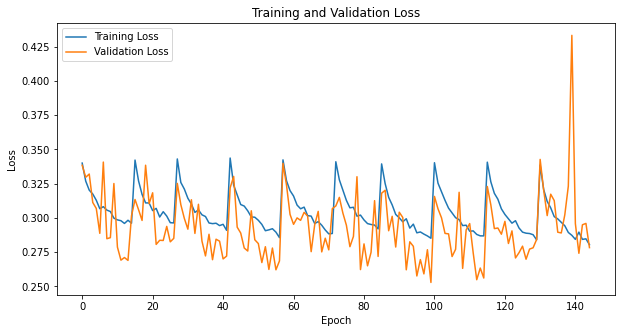

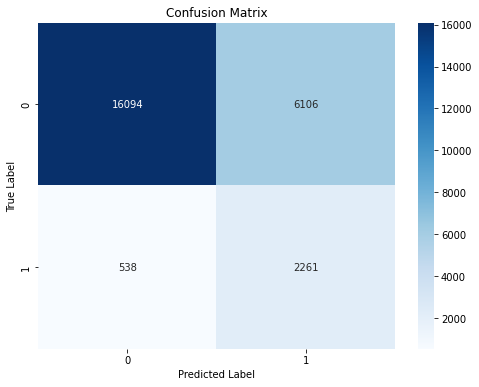

None


In [66]:
X, y = np.concatenate([X_train, X_val, X_eval]), np.concatenate([y_train, y_val, y_eval])

model = Net1D(in_channels=1, num_classes=1).to(device)
results = cross_validate(model, X, y, num_folds=10, num_epochs=15)
print(results)

In [67]:
model.eval()
probs = []
preds = []
labels = []
study_ids = []

with torch.no_grad():
    for inputs, target, study_id_batch in zip(eval_loader.dataset.tensors[0], eval_loader.dataset.tensors[1], study_ids_eval):
        inputs = inputs.unsqueeze(0).to(device) 
        target = target.to(device)
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        predictions = (probabilities > 0.1).astype(int)

        probs.extend(probabilities.flatten())
        preds.extend(predictions.flatten())
        labels.extend(target.cpu().numpy().flatten())

        study_ids.append(study_id_batch)

probs = np.array(probs)
preds = np.array(preds).astype(str)
labels = np.array(labels).astype(str)
study_ids = np.array(study_ids).astype(str)

results_df = pd.DataFrame({
    'study_id': study_ids,
    'PROB': probs,
    'PRED': preds,
    'LABEL': labels
})

print(results_df.head())

results_df.to_csv('new_directory/result/second_ex.csv', index=False)

   study_id      PROB PRED LABEL
0  44347615  0.032379    0   0.0
1  47281953  0.069420    0   0.0
2  47581754  0.007091    0   0.0
3  48171341  0.045116    0   0.0
4  47686384  0.002681    0   0.0


In [68]:
from sklearn.metrics import classification_report

preds = preds.astype(int)
y_eval = y_eval.astype(int)

report = classification_report(y_eval, preds, target_names=["Class 0", "Class 1"])
print(report)


              precision    recall  f1-score   support

     Class 0       0.96      0.80      0.87      3655
     Class 1       0.35      0.78      0.48       495

    accuracy                           0.80      4150
   macro avg       0.65      0.79      0.68      4150
weighted avg       0.89      0.80      0.83      4150

